In [15]:
%matplotlib inline
import warnings; warnings.simplefilter('ignore')  # hide warnings 

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import particles.mcmc as mcmc
import particles.state_space_models as ssm
import particles.distributions as dists
import seaborn

## Problem

The data are constituted of two independent counts of kangaroos population in New South Wales (Australia). Data are from Knape & De Valpine (2012). We aim to fit different population growth models on the historical data in order to predict the unobserved real population size from the countings.

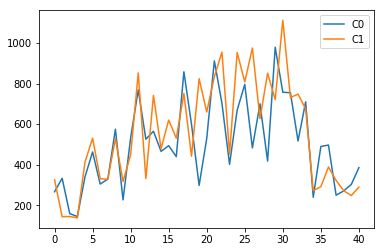

In [16]:
data = pd.read_csv("data.csv",index_col=0)
data.columns = ['C0','C1','time']
data[['C0','C1']].plot()

In [17]:
dt = data['time'].diff()
y = np.array(data[['C0', 'C1']])

def y_to_list(y):
    y_list=[]
    for i in range(y.shape[0]):
        y_list.append(np.array([y[i]]))
    return(y_list)
y = y_to_list(y)
    
mean_N0 = y[0].mean()
std_N0 = y[0].std()
print(mean_N0, std_N0)

296.5 29.5


In [49]:
n_particles = 4000
n_iter = 1000

## Definition of a Logistic Diffusion State-Space Model

The `LogisticDiffusion` state-space model is a model with the following dynamic for the unobserved variable:

$$ \frac{dy_t}{y_t} = (r+\frac{\sigma^2}{2}-b\times y_t)dt + \sigma dW_t$$

In our experiments we are just going to discretize this equation as follow:

$$ log(y_{t+1}) = log(y_t) + (r+\frac{\sigma^2}{2}-b\times y_t)\Delta_t + \sigma N(0, \Delta_t) $$

If we implement the model considering $z_t = log(y_t)$, we simply get:

$$ z_{t+1} \sim N(z_t + (r+\frac{\sigma^2}{2}-b\times exp(z_t))\Delta_t, \Delta_t )$$ 

This is the transition equation, for the emission equation we simply use a negative binomial distribution with mean $y_t$ and variance $y_t + \tau y_t^2$.

In Knape & De Valpine (2012), three models are considered:
* Model 1: parameters are r, b, $\sigma$
* Model 2: b=0, parameters are r and $\sigma$
* Model 3: r=b=0, the only parameter is $\sigma$

So actually the three models can be implemented using the same state space models class if we consider the above discretization as enough accurate for this experiment.

ToDO: Implement the model and correct priors with parameters r, b, sigma
The model can be implemented for log inputs to directly get normal distributions (and not lognormal): we have to think to log the inputs when we get the real data.

In [19]:
class LogisticDiffusion2D(ssm.StateSpaceModel):
    default_parameters={'r': 0., 'b': 0., 'sigma': 0.01, 'k':0.001}
    
    def PX0(self):
        return dists.Normal(loc=np.log(mean_N0),scale=0.01)
    
    def PX(self, t, xp):
        loc = xp+(self.r-self.sigma**2/2+self.b*np.exp(xp))*dt[t]
        return dists.Normal(loc=loc,scale=self.sigma*np.sqrt(dt[t]))
    
    def PY(self, t, xp, x):
        return dists.IndepProd(dists.NegativeBinomial(n=1/self.k, p=1/(1+self.k*np.exp(x))),
                               dists.NegativeBinomial(n=1/self.k, p=1/(1+self.k*np.exp(x))))

In [20]:
def simulate_plot(model):
    x, y = model.simulate(41)
    y = np.asarray(y)[:,0,:]
    plt.plot(np.exp(x))
    plt.plot(y)

### Some samples for the three state-space models using LogisticDiffusion2D

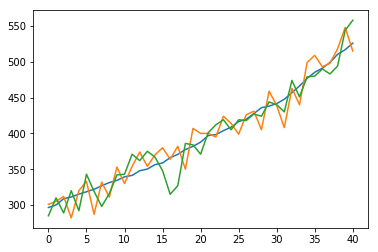

In [21]:
my_LD_ssm1 = LogisticDiffusion2D(r=0.005,b=1e-4,sigma=0.01,k=0.0001)
simulate_plot(my_LD_ssm1)

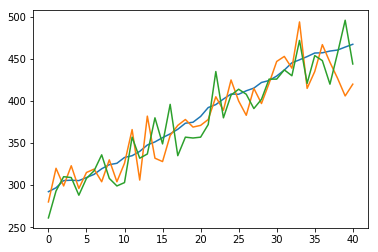

In [22]:
my_LD_ssm2 = LogisticDiffusion2D(r=0.05,b=0.,sigma=0.01,k=0.0001)
simulate_plot(my_LD_ssm2)

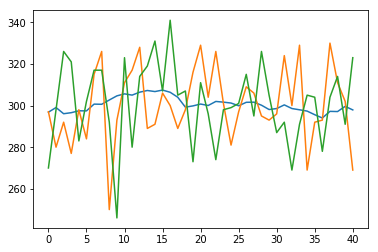

In [23]:
my_LD_ssm3 = LogisticDiffusion2D(r=0.,b=0.,sigma=0.01,k=0.0001)
simulate_plot(my_LD_ssm3)

The author results show that the Random Walk model actually fits the data better. This is no surprise as plotting the counts seems to exhibit no particular drift.

We first try basic PFMCMC algorithms using the `particles` package implemented by Nicolas Chopin, from the most simple model to the most complicated one. Below are some functions that will help display the results.

In [57]:
def plot_theta(prior, model):
    for p in prior.keys():
        plt.figure()
        plt.plot(model.chain.theta[p])
        plt.xlabel('iter')
        plt.ylabel(p)
    plt.figure()
    plt.plot(model.chain.lpost)
    plt.xlabel('iter')
    plt.ylabel('lpost')
    plt.show()
    
def print_metrics(model):
    model.compute_post()
    print('mean square jump distance: {}'.format(model.mean_sq_jump_dist(discard_frac=0.1)))
    print('posterior loglikelihood: {}'.format(model.prop.lpost))
    print('Acceptance rate: {}'.format(model.acc_rate))
    print('Last terms of theta chain: {}'.format(model.chain.theta[-5:]))

## Tests with all models

We don't use LogisticDiffusion2D for all tests are we are not yet sure about how to implement the prior to make the MH algorithm work. So we redefine a model class for all of the test and then run the PFMCMC for all of these models.

### A Random Walk Model with Poisson emission distribution

In [25]:
class RandomWalk2D_poisson(ssm.StateSpaceModel):
    default_parameters={'sigma': 0.01}
    
    def PX0(self):
        return dists.Normal(loc=np.log(mean_N0),scale=0.01)
    
    def PX(self, t, xp):
        return dists.Normal(loc=xp,scale=self.sigma*np.sqrt(dt[t]))
    
    def PY(self, t, xp, x):
        return dists.IndepProd(dists.Poisson(rate=np.exp(x)),
                               dists.Poisson(rate=np.exp(x)))

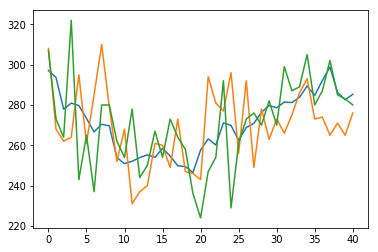

In [26]:
RWp = RandomWalk2D_poisson(sigma=0.05)
simulate_plot(RWp)

In [27]:
prior_RWp = {'sigma': dists.Uniform(a=0.,b=10.)}

p_RWp = dists.StructDist(prior_RWp)

pmmh_RWp= mcmc.PMMH(ssm_cls=RandomWalk2D_poisson, prior=p_RWp, data=y, Nx=n_particles, niter=n_iter, adaptive=True)
pmmh_RWp.run()

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [16:08<00:00, 20.66it/s]


mean square jump distance: 100.2037484900946
posterior loglikelihood: [-1072.7321948]
Acceptance rate: 0.3798689934496725
Last terms of theta chain: [(0.71637592,) (0.91526238,) (0.91242504,) (0.87297818,) (0.87297818,)]


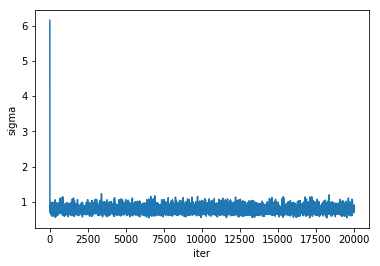

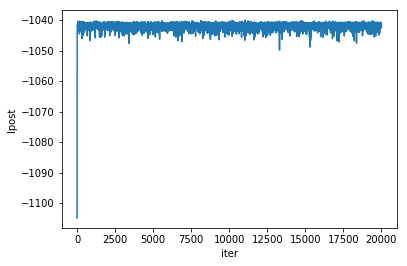

In [58]:
print_metrics(pmmh_RWp)
plot_theta(prior_RWp, pmmh_RWp)

In [56]:
RWp = RandomWalk2D_poisson(sigma=0.05)
#simulate_plot(RWp)
pmmh_RWp.chain.__dict__

{'theta': array([(6.15169842,), (6.15169842,), (2.1030235 ,), ..., (0.91242504,),
        (0.87297818,), (0.87297818,)], dtype=[('sigma', '<f8')]),
 'lpost': array([-1104.89755424, -1104.89755424, -1064.72805981, ...,
        -1042.39409536, -1042.1087474 , -1042.1087474 ]),
 'containers': ['theta', 'lpost'],
 'arr': array([[6.15169842],
        [6.15169842],
        [2.1030235 ],
        ...,
        [0.91242504],
        [0.87297818],
        [0.87297818]]),
 'N': 20000,
 'dim': 1}

## Random Walk Model (M3)

In [29]:
class RandomWalk2D(ssm.StateSpaceModel):
    default_parameters={'sigma': 0.01, 'k':0.001}
    
    def PX0(self):
        return dists.Normal(loc=np.log(mean_N0),scale=0.01)
    
    def PX(self, t, xp):
        return dists.Normal(loc=xp,scale=self.sigma*np.sqrt(dt[t]))
    
    def PY(self, t, xp, x):
        return dists.IndepProd(dists.NegativeBinomial(n=1/self.k, p=1/(1+self.k*np.exp(x))),
                               dists.NegativeBinomial(n=1/self.k, p=1/(1+self.k*np.exp(x))))

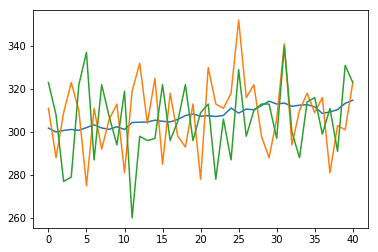

In [30]:
RW = RandomWalk2D(sigma=0.01,k=0.0001)
simulate_plot(RW)

In [31]:
prior_RW = {'k': dists.Uniform(a=0.,b=1.),
             'sigma': dists.Uniform(a=0.,b=10.)}

p_RW = dists.StructDist(prior_RW)

pmmh_RW= mcmc.PMMH(ssm_cls=RandomWalk2D, prior=p_RW, data=y, Nx=n_particles, niter=n_iter, adaptive=True)
pmmh_RW.run()

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [24:54<00:00, 13.38it/s]


mean square jump distance: 125.37391357150635
posterior loglikelihood: [-540.0827742]
Acceptance rate: 0.3429671483574179
Last terms of theta chain: [(0.07466812, 0.37362164) (0.07709054, 0.47293027)
 (0.07709054, 0.47293027) (0.07709054, 0.47293027)
 (0.07709054, 0.47293027)]


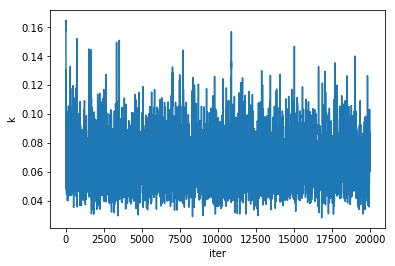

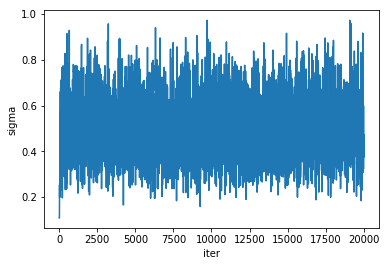

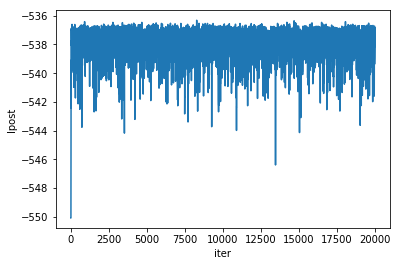

In [59]:
print_metrics(pmmh_RW)
plot_theta(prior_RW,pmmh_RW)

## Logistic Diffusion process with drift (M2)

In [33]:
class LDPDrift(ssm.StateSpaceModel):
    default_parameters={'sigma': 0.01, 'k':0.001, 'r':0.005}
    
    def PX0(self):
        return dists.Normal(loc=np.log(mean_N0),scale=0.01)
    
    def PX(self, t, xp):
        return dists.Normal(loc=xp+self.r*dt[t],scale=self.sigma*np.sqrt(dt[t]))
    
    def PY(self, t, xp, x):
        return dists.IndepProd(dists.NegativeBinomial(n=1/self.k, p=1/(1+self.k*np.exp(x))),
                               dists.NegativeBinomial(n=1/self.k, p=1/(1+self.k*np.exp(x))))

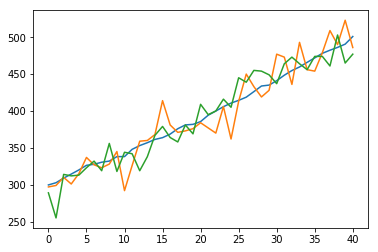

In [48]:
Ldrift = LDPDrift(sigma=0.01,k=0.0001, r=0.05)
simulate_plot(Ldrift)

In [50]:
prior_Ldrift = {'k': dists.Uniform(a=0.,b=1.),
             'sigma': dists.Uniform(a=0.,b=10.), 'r':dists.Uniform(a=-0.05, b=0.05)}

p_Ldrift = dists.StructDist(prior_Ldrift)

pmmh_Ldrift= mcmc.PMMH(ssm_cls=LDPDrift, prior=p_Ldrift, data=y, Nx=n_particles, niter=n_iter, adaptive=True)
pmmh_Ldrift.run()

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:05<00:00, 15.34it/s]


mean square jump distance: 4.045423290545394
posterior loglikelihood: [-538.94357797]
Acceptance rate: 0.3433433433433433
Last terms of theta chain: [(0.05234633, -0.03866725, 0.33286491)
 (0.07382264,  0.03199044, 0.4152781 )
 (0.04613982, -0.02495948, 0.55428428)
 (0.05377569, -0.03812062, 0.63628042)
 (0.05377569, -0.03812062, 0.63628042)]


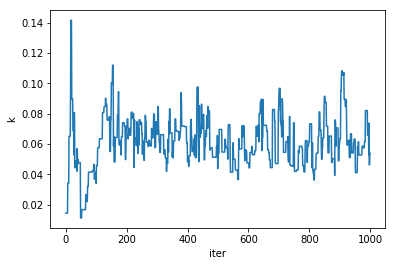

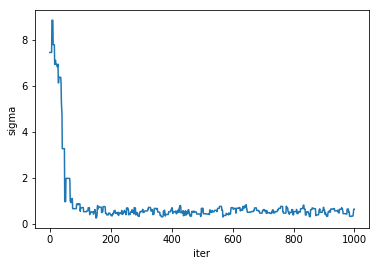

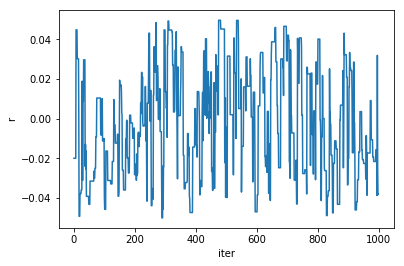

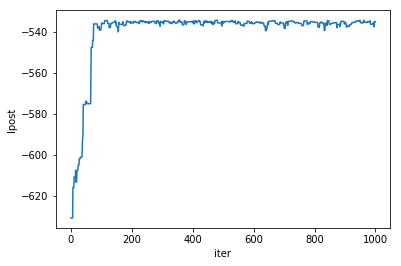

In [60]:
print_metrics(pmmh_Ldrift)
plot_theta(prior_Ldrift,pmmh_Ldrift)

## Logistic Diffusion process with drift and restoring force (M1)

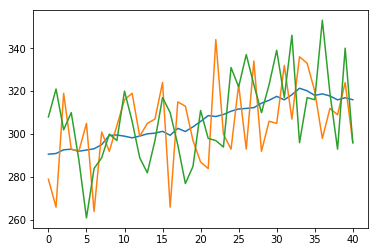

In [37]:
LD = LogisticDiffusion2D(sigma=0.01,k=0.0001, r=0.005, b=1e-6)
simulate_plot(Ldrift)

In [52]:
prior_LD = {'k': dists.Uniform(a=0.,b=1.), 'b': dists.Uniform(a=0., b=1e-2),
             'sigma': dists.Uniform(a=0.,b=10.), 'r':dists.Uniform(a=-0.05, b=0.05)}

p_LD = dists.StructDist(prior_LD)

pmmh_LD= mcmc.PMMH(ssm_cls=LogisticDiffusion2D, prior=p_LD, data=y, Nx=n_particles, niter=n_iter, adaptive=True)
pmmh_LD.run()

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:01<00:00, 16.15it/s]


mean square jump distance: 0.6933900550347765
posterior loglikelihood: [-inf]
Acceptance rate: 0.25225225225225223
Last terms of theta chain: [(0.00022338, 0.05790863,  0.00791672, 0.7414522 )
 (0.00022338, 0.05790863,  0.00791672, 0.7414522 )
 (0.00024146, 0.04963241, -0.02349188, 0.60435982)
 (0.00024146, 0.04963241, -0.02349188, 0.60435982)
 (0.00024146, 0.04963241, -0.02349188, 0.60435982)]


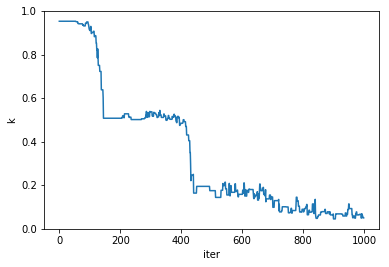

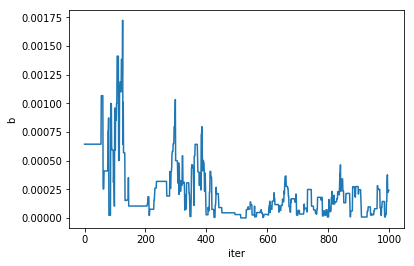

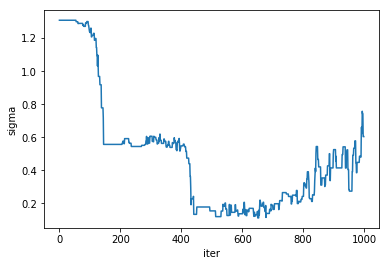

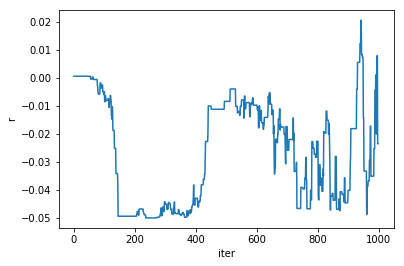

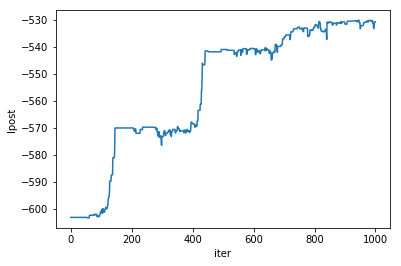

In [61]:
print_metrics(pmmh_LD)
plot_theta(prior_LD,pmmh_LD)